# Diary for CRBM implementation



This notebook shows the parts from `crbm.py` with some details

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np 
import pandas as pd
import numexpr as ne
import sklearn
from sklearn import preprocessing



##### read data from  `../Datasets/motion.mat`

More data from human motion captures can be found here:

http://people.csail.mit.edu/ehsu/work/sig05stf/

In [2]:
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
data = loadmat('../Datasets/motion.mat')

In [3]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'skel', 'Motion'])

In [4]:
X1 = data["Motion"][0][0]
X2 = data["Motion"][0][1]
X3 = data["Motion"][0][2]

In [5]:
X1.shape, X2.shape, X2.shape

((1750, 108), (1040, 108), (1040, 108))

Several features are 0

In [6]:
#(X1 - np.min(X1,0)) / (np.max(X1,0) - np.min(X1,0))* (np.min(X1,0) != 0)

In [7]:
X1[:,3].min(), X1[:,3].max(), X1.shape

(-1049.559326171875, 490.09881591796881, (1750, 108))

In [8]:
n_features = X1.shape[1]
for f in range(n_features):
    max_val, min_val =  X1[:, f].max(), X1[:, f].min()
    if (max_val - min_val) != 0:
        X1[:, f] = ( X1[:, f]  - min_val)  / (max_val - min_val)
    else:
        #print(f, max_val, max_val)
        X1[:, f] = ( X1[:, f]  - min_val) # / (max_val - min_val)


In [9]:
X1.min(), X1.max()

(0.0, 1.0)

### CRBM class

In [10]:
a = 10
b=2
np.zeros([a,b])

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

### Notes on the weight initialization

A relevant aspect of learning algorithms is the initial magnitude of the weights. It turns out that the magnitude of the weights in a layer can impact the net input of the layer above and this can lead to unnexpected error. In the case of the RBM the Bernoulli hidden units generate samples acording to a logistic. Since the logistic contains an exponential this can lead to numerical problems if the numbers in the exponential are big.

#### Scaling using a fixed min-max interval

In order to facilitate introducing the problem we can start with a concrete example and generalize from there. Let us assume we have 500 visible units and 100 visible units. Let us consider a visible vector with values between 
0 and 1. Then the net input of hidden unit $i$ will be

$$
z_i = {\boldsymbol W_i} \cdot {\boldsymbol  x} + b_i
$$

If we  initialize ${\boldsymbol W_i} $ to have values in $[-0.5, 0.5]$  and $b_i=0$ then 

$$
{\boldsymbol W_i} \cdot {\boldsymbol  x}  \leq 0.5 * 1 + \dots 0.5 * 1 = 500*0.5 = 250
$$

In the worst case scenario when computing the sigmoid of that value we will have:

$$
   a_i = \frac{1}{1 + \text{e}^{-250}}
$$

We can easily run into numerical problems for the exponential of a number with "big magnitude".

#### Scaling taking into acount the number of units in the layers

Let us consider the same example as above but where we scale the weights by the maximum of the number of hidden units and visible units. In this case 500. Now all of a sudden

$$
{\boldsymbol W_i} \cdot {\boldsymbol  x}  \leq \frac{0.5}{500}  1 + \dots \frac{0.5}{500}  1 = 500 \cdot \frac{0.5}{500} = 0.5
$$

What whould happen now if we conside that we have an input layer with 100000 units? Well the maximum net input of the initial weights is ensured to be equal to the maximum value achievable in the input feature space.

$$
{\boldsymbol W_i} \cdot {\boldsymbol  x}  \leq \frac{0.5}{100000 }  1 + \dots \frac{0.5}{100000 }  1 = 100000  \cdot \frac{0.5}{100000} = 0.5
$$



In [96]:
class CRBM:
    def __init__(self, n_vis, n_hid, n_cond, seed=42, sigma=0.2, monitor_time=True, scale_factor = 0):

        self.previous_xneg = None
        np.random.seed(seed)
        
        if scale_factor == 0:
            scale_factor = 1./( n_vis * n_cond)
        #scale_factor = n_vis + n_cond
        
        W = scale_factor * np.random.normal(0, sigma, [n_hid, n_vis])   # vis to hid
        A = scale_factor * np.random.normal(0, sigma, [n_vis, n_vis * n_cond])  # cond to vis
        B = scale_factor * np.random.normal(0, sigma, [n_hid, n_vis * n_cond])  # cond to hid

        v_bias = np.zeros([n_vis, 1]) 
        h_bias = np.zeros([n_hid, 1])

        dy_v_bias = np.zeros([n_vis, 1])
        dy_h_bias = np.zeros([n_hid, 1])

        self.W = np.array(W, dtype='float32')
        self.A = np.array(A, dtype='float32')
        self.B = np.array(B, dtype='float32')
        self.v_bias = v_bias
        self.h_bias = h_bias
        self.dy_v_bias = dy_v_bias
        self.dy_h_bias = dy_h_bias
        self.scale_factor = scale_factor
        
        self.n_vis = n_vis
        self.n_hid = n_hid
        self.n_his = n_cond
        
        self.num_epochs_trained = 0
        self.lr = 0
        self.monitor_time = monitor_time

In [12]:
crbm = CRBM(n_vis=108, n_hid=256, n_cond=20, seed=123, sigma = 0.3)

In [13]:
crbm.W.shape, crbm.A.shape, crbm.B.shape

((256, 108), (108, 2160), (256, 2160))

### Auxiliary functions

In [14]:
def sig(v):
    return ne.evaluate("1/(1 + exp(-v))")

def split_vis(crbm: CRBM, vis: np.ndarray):
    n_his = vis.shape[0]
    cond = vis[0:(n_his-1), :].T
    x = vis[[n_his-1],:].T
    
    assert  crbm.n_vis == x.shape[0] and crbm.n_vis == cond.shape[0], \
            "crbm.n_vis = {}, is different from x.shape[0] = {} or cond.shape[0] = {}".format(crbm.n_vis,
                                                                                                  x.shape[0],
                                                                                                  cond.shape[0])
    return x, cond


def dynamic_biases_up(crbm: CRBM, cond: np.ndarray):
    crbm.dy_v_bias = np.dot(crbm.A, cond) + crbm.v_bias 
    crbm.dy_h_bias = np.dot(crbm.B, cond) + crbm.h_bias
        
        
def hid_means(crbm: CRBM, vis: np.ndarray):
    p = np.dot(crbm.W, vis) + crbm.dy_h_bias
    return sig(p)
    
    
def vis_means(crbm: CRBM, hid: np.ndarray):   
    p = np.dot(crbm.W.T, hid) + crbm.dy_v_bias
    return sig(p)


In [15]:
X = X1[0:21, :]
X.shape, crbm.n_his

((21, 108), 20)

In [16]:
vis, cond = split_vis(crbm, X)
vis.shape, cond.shape

((108, 1), (108, 20))

### Compute gradients

```
function gibbs(rbm::AbstractRBM, vis::Mat; n_times=1)
    v_pos = vis
    h_pos = sample_hiddens(rbm, v_pos)
    v_neg = sample_visibles(rbm, h_pos)
    h_neg = sample_hiddens(rbm, v_neg)
    for i=1:n_times-1
        v_neg = sample_visibles(rbm, h_neg)
        h_neg = sample_hiddens(rbm, v_neg)
    end
    return v_pos, h_pos, v_neg, h_neg
end
```

In [17]:

def sample_hiddens(crbm: CRBM, v: np.ndarray, cond: np.ndarray):
    h_mean = sig( np.dot(crbm.W, v) +  np.dot(crbm.B, cond) + crbm.h_bias)
    h_sample = h_mean > np.random.random(h_mean.shape).astype(np.float32)
    return h_sample, h_mean


def sample_visibles(crbm: CRBM, h: np.ndarray, cond: np.ndarray):
    """
    Notice we don't sample or put the sigmoid here since visible units are Gaussian
    """
    v_mean = np.dot(crbm.W.T, h) + np.dot(crbm.A, cond) + crbm.v_bias  
    return v_mean


In [18]:
def CDK(crbm, vis,cond, K=1):
    v_pos_mean = vis
    h_pos_sample, h_pos_mean    = sample_hiddens(crbm,  v_pos_mean, cond)
    v_neg_mean                  = sample_visibles(crbm, h_pos_mean, cond)
    h_neg_sample, h_neg_mean    = sample_hiddens(crbm,  v_neg_mean, cond)

    for i in range(K-1):
        v_neg_mean           = sample_visibles(crbm, h_neg_mean, cond)
        h_neg, h_neg_mean    = sample_hiddens(crbm,  v_neg_mean, cond)
    
    return v_pos_mean, h_pos_mean , v_neg_mean, h_neg_mean

### Update history in matrix form

In [19]:
a = np.array([[3,3,3],[2,2,2],[1,1,1]]).T
a

array([[3, 2, 1],
       [3, 2, 1],
       [3, 2, 1]])

In [20]:
a[:,0:-1] = a[:,1:]
a

array([[2, 1, 1],
       [2, 1, 1],
       [2, 1, 1]])

In [21]:
a[:,-1] = [7,7,7]
a

array([[2, 1, 7],
       [2, 1, 7],
       [2, 1, 7]])

In [22]:
def update_history_as_mat(current_hist, vec_to_hist):
    current_hist[:,0:-1] = current_hist[:,1:]
    current_hist[:,-1] = vec_to_hist
    return current_hist

In [23]:
a = np.array([[3,3,3],[2,2,2],[1,1,1]]).T
v = np.array([7,7,7])
update_history_as_mat(a, v)

array([[2, 1, 7],
       [2, 1, 7],
       [2, 1, 7]])

### Update history in column vector form

Notice that first column in the matrix corresponds to oldest feature vector (first to be popped out):

In [24]:
a = np.array([[3,3,3],[2,2,2],[1,1,1]]).T
a

array([[3, 2, 1],
       [3, 2, 1],
       [3, 2, 1]])

In [25]:
# This is what we want to do
a = np.array([a.flatten('F')]).T
a

array([[3],
       [3],
       [3],
       [2],
       [2],
       [2],
       [1],
       [1],
       [1]])

In [26]:
v_new = np.array([[7,7,7]]).T
n_feat = v_new.shape[0]
v_new

array([[7],
       [7],
       [7]])

In [27]:
a[0:-n_feat] = a[n_feat:] 
a

array([[2],
       [2],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [28]:
a[-3:] = v_new
a

array([[2],
       [2],
       [2],
       [1],
       [1],
       [1],
       [7],
       [7],
       [7]])

In [29]:
def update_history_as_vec(current_hist_vec, v_new):
    n_feat = v_new.shape[0]
    current_hist_vec[0:-n_feat] = current_hist_vec[n_feat:] 
    current_hist_vec[-n_feat:] = v_new
    return current_hist_vec

In [30]:
a = np.array([[3,3,3],[2,2,2],[1,1,1]]).T
a = np.array([a.flatten('F')]).T

update_history_as_vec(a, v_new)

array([[2],
       [2],
       [2],
       [1],
       [1],
       [1],
       [7],
       [7],
       [7]])

### Gradient computation

In [31]:
def history_mat_to_vec(cond):
    return np.array([cond.flatten('F')]).T

In [32]:
def compute_gradient(crbm, X):
    """
    Computes an approximated gradient of the likelihod (for a given minibatch X) with
    respect to the parameters. 
    """
    vis, cond = split_vis(crbm, X)
    cond = history_mat_to_vec(cond)
        
    v_pos, h_pos, v_neg, h_neg = CDK(crbm, vis, cond)
    n_obs = vis.shape[1]
    
    # for a sigle observation:  dW = h * v^T - h_hat * v_hat^T
    dW = ( np.dot(h_pos, v_pos.T) - np.dot(h_neg, v_neg.T) ) * (1./n_obs)
    dA = ( np.dot(v_pos, cond.T)  - np.dot(v_neg, cond.T)  ) * (1./n_obs)
    dB = ( np.dot(h_pos, cond.T)  - np.dot(h_neg, cond.T)  ) * (1./n_obs) 
    
    dv_bias = np.mean(v_pos - v_neg, axis=1, keepdims=True)
    dh_bias = np.mean(h_pos - h_neg, axis=1, keepdims=True)
    #print("n_obs:", n_obs)
    
    rec_error = np.linalg.norm(v_pos - v_neg)
    #print( np.sqrt(np.sum((v_pos - v_neg)**2)))
    
    return dW, dA, dB, dv_bias, dh_bias, rec_error

In [33]:
X = X1[0:21,:]

In [34]:
X.shape, crbm.n_his

((21, 108), 20)

In [35]:
# Notice that the history is converted to a "long column vector" concatenating
# all the rows of the n_his vectors into a single vector of `n_vis * n_his` elements.
# This is done by `cond = np.array([cond.flatten()]).T`

dW, dA, dB, dv_bias, dh_bias, rec_error = compute_gradient(crbm, X)

In [36]:
X.shape, rec_error

((21, 108), 3.7833759486224965)

### SGD  example

In [37]:
def update_weights_sgd(crbm, grads, learning_rate):
    
    dW, dA, dB, dv_bias, dh_bias = grads #rec_error = compute_gradient(crbm, X)
    crbm.W += dW * learning_rate
    crbm.A += dA * learning_rate
    crbm.B += dB * learning_rate
    
    crbm.v_bias += dv_bias * learning_rate
    crbm.h_bias += dh_bias * learning_rate

In [38]:
crbm = CRBM(n_vis=108, n_hid=256, n_cond=20, seed=123, sigma = 0.3)
learning_rate = 0.001

for i in range(10):
    dW, dA, dB, dv_bias, dh_bias, err = compute_gradient(crbm, X)
    grads  = (dW, dA, dB, dv_bias, dh_bias)
    update_weights_sgd(crbm, grads,  learning_rate)
    print("reconstruction error:", err)

reconstruction error: 3.78337594862
reconstruction error: 2.41012258836
reconstruction error: 1.53358720715
reconstruction error: 0.974943280007
reconstruction error: 0.619385008974
reconstruction error: 0.393317339107
reconstruction error: 0.24968532226
reconstruction error: 0.158473379117
reconstruction error: 0.100568883797
reconstruction error: 0.063816797377


### SGD Minibatch

In [39]:
X.shape, crbm.n_his

((21, 108), 20)

In [40]:
X.shape

(21, 108)

### Apply momentum

In [41]:
def update_weights_sgd_momentum(crbm, grads, learning_rate, ctx, momentum=0.9):
    
    dW, dA, dB, dv_bias, dh_bias = grads 
    
    ctx["W_vel"]        = ctx["W_vel"]      * momentum    +  dW      * learning_rate
    ctx["A_vel"]        = ctx["A_vel"]      * momentum    +  dA      * learning_rate
    ctx["B_vel"]        = ctx["B_vel"]      * momentum    +  dB      * learning_rate
    ctx["v_bias_vel"]   = ctx["v_bias_vel"] * momentum    +  dv_bias * learning_rate
    ctx["h_bias_vel"]   = ctx["h_bias_vel"] * momentum    +  dh_bias * learning_rate
    
    crbm.W += ctx["W_vel"]
    crbm.A += ctx["A_vel"] 
    crbm.B += ctx["B_vel"] 
    
    crbm.v_bias += ctx["v_bias_vel"]
    crbm.h_bias += ctx["h_bias_vel"]

In [42]:
crbm = CRBM(n_vis=108, n_hid=256, n_cond=20, seed=123, sigma = 0.3)
learning_rate = 0.001

ctx = { "W_vel" : np.zeros(crbm.W.shape), 
        "A_vel" : np.zeros(crbm.A.shape),
        "B_vel" : np.zeros(crbm.B.shape), 
        "v_bias_vel" : np.zeros(crbm.v_bias.shape), 
        "h_bias_vel" : np.zeros(crbm.h_bias.shape)}

for i in range(10):
    dW, dA, dB, dv_bias, dh_bias, err = compute_gradient(crbm, X)
    grads  = (dW, dA, dB, dv_bias, dh_bias)
    update_weights_sgd_momentum(crbm, grads, learning_rate, ctx, momentum=0.2)
    print("reconstruction error:", err)

reconstruction error: 3.78337594862
reconstruction error: 2.41012258836
reconstruction error: 1.25849845438
reconstruction error: 0.56923316708
reconstruction error: 0.223516062067
reconstruction error: 0.0726995199743
reconstruction error: 0.0159650091587
reconstruction error: 0.00121751691281
reconstruction error: 0.00420901999359
reconstruction error: 0.00326888605879


### Get slice of data

Given a timeseries where column `k` corresponds to a feature vector for the measurements of the timeseries at time `k`, we would like to take a slice of `n_his` values to feed the CRBM with a visible vector and a history.

In [43]:
X.shape

(21, 108)

In [44]:
def get_slice_at_position_k(X, k, n_his):
    """
    Returns a slice of shape  `(n_his + 1)` with the last column beeing the visible
    vector at the current time step `k`.
    """
    assert k > n_his, "Position k = {} is lower than n_his = {}".format(k, n_his)
    assert k <= X.shape[1], "Position k = {} is bigger than number of timesteps of X.shape[1] = {}".format(k, X.shape[0])
    return X[:, (k-(n_his+1)):k]

In [45]:
X_tr = X1.T
print("X_tr shape: ", X_tr.shape, "\nslice shape:", get_slice_at_position_k(X_tr, 520, crbm.n_his).shape)

X_tr shape:  (108, 1750) 
slice shape: (108, 21)


### Train some  epochs 

In [46]:
X_tr = X1.T
X_tr.shape, X_tr.shape[1],  crbm.n_vis, crbm.n_hid, crbm.n_his

((108, 1750), 1750, 108, 256, 20)

#### Without momentum


In [108]:
%%time
crbm = CRBM(n_vis=108, n_hid=256, n_cond=20, seed=123, sigma = 0.3)
n_epochs = 10
learning_rate = 0.005 # we have increased the  learning rate

for n in range(n_epochs):
    err_epoch = 0
    iters = 0
    for k in range(crbm.n_his + 1, X_tr.shape[1] ):

        X_curr = get_slice_at_position_k(X_tr, k, crbm.n_his)
        dW, dA, dB, dv_bias, dh_bias, rec_error = compute_gradient(crbm, X_curr.T)
        grads = (dW, dA, dB, dv_bias, dh_bias)
        update_weights_sgd(crbm, grads,  learning_rate)
        iters +=1
        err_epoch += rec_error
        
    print("rec error: ", err_epoch/iters)#, end="\r")

rec error:  0.26389287368
rec error:  0.157275116496
rec error:  0.150250980588
rec error:  0.14404855055
rec error:  0.140835078679
rec error:  0.1358751415
rec error:  0.133247844813
rec error:  0.13088396841
rec error:  0.128474658278
rec error:  0.126519101202
CPU times: user 6min 50s, sys: 14.7 s, total: 7min 5s
Wall time: 3min 35s


#### With momentum


In [47]:
%%time
crbm = CRBM(n_vis=108, n_hid=256, n_cond=20, seed=123, sigma = 0.3)
n_epochs = 10
learning_rate = 0.001

ctx = { "W_vel" : np.zeros(crbm.W.shape), 
        "A_vel" : np.zeros(crbm.A.shape),
        "B_vel" : np.zeros(crbm.B.shape), 
        "v_bias_vel" : np.zeros(crbm.v_bias.shape), 
        "h_bias_vel" : np.zeros(crbm.h_bias.shape)}

for n in range(n_epochs):
    err_epoch = 0
    iters = 0
    for k in range(crbm.n_his + 1, X_tr.shape[1] ):

        X_curr = get_slice_at_position_k(X_tr, k, crbm.n_his)
        dW, dA, dB, dv_bias, dh_bias, rec_error = compute_gradient(crbm, X_curr.T)
        grads = (dW, dA, dB, dv_bias, dh_bias)
        update_weights_sgd_momentum(crbm, grads, learning_rate, ctx, momentum=0.2)
        iters +=1
        err_epoch += rec_error
        
    print("rec error: ", err_epoch/iters)#, end="\r")

rec error:  0.217831253038
rec error:  0.205777576279
rec error:  0.200893142104
rec error:  0.192539693971
rec error:  0.190128312883
rec error:  0.184177126557
rec error:  0.181172568991
rec error:  0.177286164251
rec error:  0.175127015776
rec error:  0.171605778243
CPU times: user 9min 56s, sys: 41.7 s, total: 10min 38s
Wall time: 5min 25s


In [106]:
%%time
crbm = CRBM(n_vis=108, n_hid=256, n_cond=20, seed=123, sigma = 0.3)
n_epochs = 10
learning_rate = 0.005

ctx = { "W_vel" : np.zeros(crbm.W.shape), 
        "A_vel" : np.zeros(crbm.A.shape),
        "B_vel" : np.zeros(crbm.B.shape), 
        "v_bias_vel" : np.zeros(crbm.v_bias.shape), 
        "h_bias_vel" : np.zeros(crbm.h_bias.shape)}

for n in range(10):
    err_epoch = 0
    iters = 0
    for k in range(crbm.n_his + 1, X_tr.shape[1] ):

        X_curr = get_slice_at_position_k(X_tr, k, crbm.n_his)
        dW, dA, dB, dv_bias, dh_bias, rec_error = compute_gradient(crbm, X_curr.T)
        grads = (dW, dA, dB, dv_bias, dh_bias)
        update_weights_sgd_momentum(crbm, grads, learning_rate, ctx, momentum=0.2)
        iters +=1
        err_epoch += rec_error
        
    print("rec error: ", err_epoch/iters)#, end="\r")

rec error:  0.127216009919
rec error:  0.122487744405
rec error:  0.120986417745
rec error:  0.118793712062
rec error:  0.118635901874
rec error:  0.116479299331
rec error:  0.116053473752
rec error:  0.114832268219
rec error:  0.115027022925
rec error:  0.113600646821
CPU times: user 9min 37s, sys: 19.8 s, total: 9min 57s
Wall time: 5min 1s


### Make predictions with the model

In [109]:
# This is a timeseries where rows are features and columns timesteps (1750 timesteps and 108 features)
X_tr.shape, X_tr[:,1].shape

((108, 1750), (108,))

In [110]:
def generate(crbm, vis, cond_as_vec, n_gibbs=10):
    """ 
    Given initialization(s) of visibles and matching history, generate a sample in the future.
    
        vis:  n_vis * 1 array
            
        cond_as_vec: n_hist * n_vis array
            
        n_gibbs : int
            number of alternating Gibbs steps per iteration
    """
    
    assert cond_as_vec.shape[1] ==1, "cond_as_vec has to be a column vector"
    
    n_seq = vis.shape[0]
    #import pdb; pdb.set_trace()
    v_pos, h_pos, v_neg, h_neg = CDK(crbm, vis, cond_as_vec, n_gibbs)
    
    return v_neg

In [111]:
def generate_n_samples(crbm, vis, cond_as_vec, n_samples, n_gibbs=10):
    """ 
    Given initialization(s) of visibles and matching history, generate a n_samples in the future.
    """
    
    assert cond_as_vec.shape[1] ==1, "cond_as_vec has to be a column vector"
    
    samples = []
    for i in range(n_samples):
        v_new = generate(crbm, vis, cond_as_vec, n_gibbs)
        
        # This should not be here
        #v_new = v_new/np.linalg.norm(v_new)      
        update_history_as_vec(cond_as_vec, v_new)
        
        samples.append(v_new)

    return samples

In [112]:
v    = X_tr[:, [crbm.n_his+1]]
hist = X_tr[:, 0:crbm.n_his+1]

In [113]:
crbm.n_vis,  v.shape, hist.shape, X.shape

(108, (108, 1), (108, 21), (21, 108))

In [114]:
vis, cond = split_vis(crbm, hist.T)

cond.shape

(108, 20)

In [115]:
cond_as_vec =  history_mat_to_vec(cond)

In [116]:
cond_as_vec.max(), cond_as_vec.min()

(0.94352132901966146, 0.0)

In [117]:
v.shape, cond_as_vec.shape, crbm.n_vis

((108, 1), (2160, 1), 108)

In [118]:
v.shape

(108, 1)

In [119]:
cond_as_vec.shape

(2160, 1)

In [120]:
crbm.A.shape, crbm.B.shape, crbm.W.shape

((108, 2160), (256, 2160), (256, 108))

In [121]:
samples = generate_n_samples(crbm, v, cond_as_vec, n_samples = 100, n_gibbs=10)

In [122]:
cond_as_vec.min()

-12.452983230864413

In [123]:
len(samples), len(samples[0])

(100, 108)

In [124]:
print(samples[0].max(), samples[0].min())
print(samples[1].max(), samples[1].min())
print(samples[2].max(), samples[2].min())
print(samples[3].max(), samples[3].min())
print(samples[4].max(), samples[4].min())
print(samples[-1].max(), samples[-1].min())

1.39164022092 -0.00221998376513
1.39489437577 -0.00260685886171
1.39563308163 -0.00265489822814
1.39661954583 -0.00222544404403
1.39637757123 -0.00231257111991
11.410042029 -12.4529832309


In [318]:
#X = X1[0:21,:]

In [125]:
y_true = X1[21:121,:]

In [126]:
y_hat = np.array(samples).reshape(100,108)

In [127]:
y_hat.shape, y_true.shape

((100, 108), (100, 108))

In [128]:
np.sqrt(np.mean((y_hat - y_true)**2))

1.5184257911418322

In [129]:
y_hat.max(), y_hat.min(), y_true.max(), y_true.min()

(16.387152984513655, -12.452983230864413, 0.9779543984237089, 0.0)

### Evaluating Loss of the generated traces.

In [155]:
np.sqrt(np.mean((y_hat[0:10] - y_true[0:10])**2))

0.18041898771687562

In [160]:
np.sqrt(np.mean((y_hat[10:20] - y_true[10:20])**2))

0.25882337874616812

In [164]:
np.sqrt(np.mean((y_hat[20:30] - y_true[20:30])**2))

0.39695289357575242

In [166]:
np.sqrt(np.mean((y_hat[30:40] - y_true[30:40])**2))

0.56388542100041383

In [140]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import tstools
from tstools import timeseries  

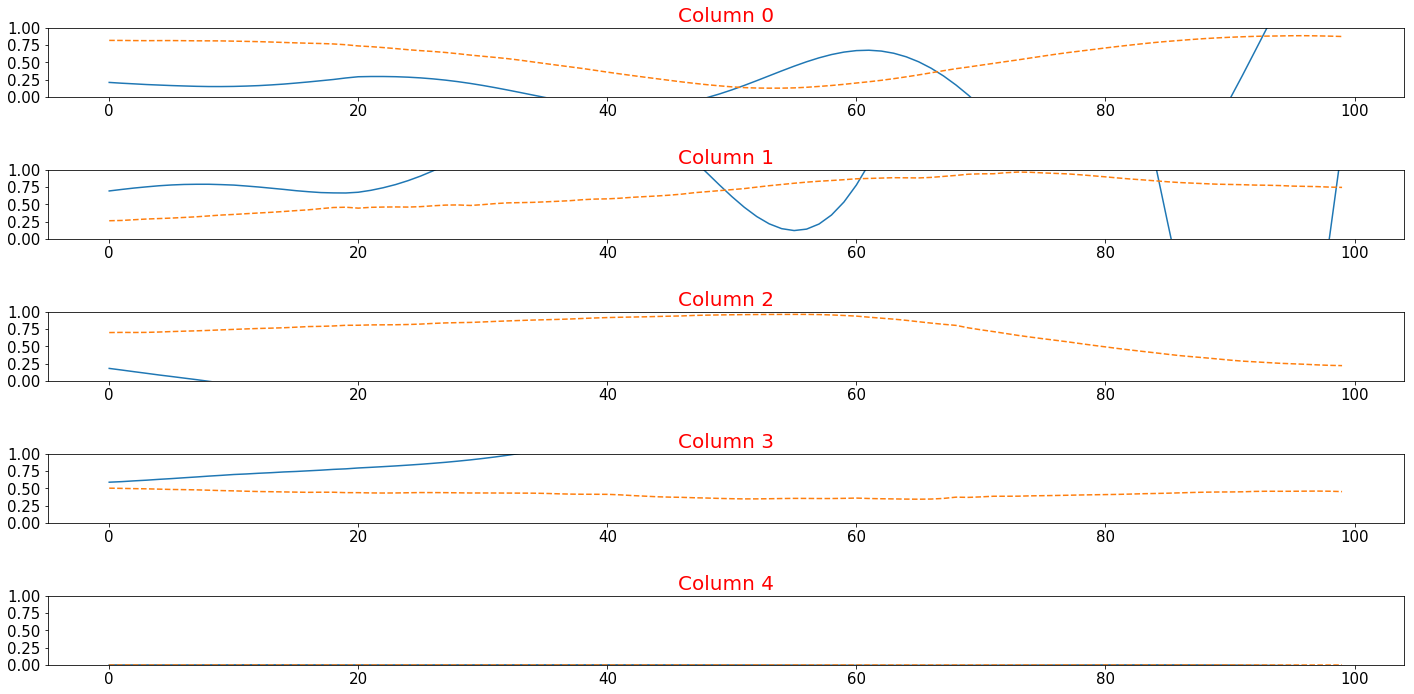

In [151]:
timeseries.plot_timeseries_overlaped(y_hat[:,5:10], y_true[:,5:10])

### Persistent chain for predictions

In [ ]:

def split_vis_rowdata(crbm: CRBM, vis: np.ndarray):
    n_his = vis.shape[0]
    cond = vis[0:(n_his-1), :].T
    x = vis[[n_his-1],:].T
    
    assert  crbm.n_vis == x.shape[0] and crbm.n_vis == cond.shape[0], \
            "crbm.n_vis = {}, is different from x.shape[0] = {} or cond.shape[0] = {}".format(crbm.n_vis,
                                                                                                  x.shape[0],
                                                                                                  cond.shape[0])
    return x, cond




def split_vis_coldata(crbm: CRBM, vis: np.ndarray):
    n_his = vis.shape[0]
    cond = vis[:, 0:(n_his-1)]
    x = vis[[n_his-1],:]
    
    assert  crbm.n_vis == x.shape[0] and crbm.n_vis == cond.shape[0], \
            "crbm.n_vis = {}, is different from x.shape[0] = {} or cond.shape[0] = {}".format(crbm.n_vis,
                                                                                                  x.shape[0],
                                                                                                  cond.shape[0])
    return x, cond

#### Making predictions with persistent chain

Prepare an example that trains with several data and predict feature values

```
forecast_crbm <- forecast.crbm <- function(crbm, orig_data, orig_history = NULL, n_samples = 10, n_gibbs = 30)
{
	if (is.null(orig_history))
	{
		l <- nrow(orig_data);
		orig_history <- orig_data[l - 1:crbm$delay,, drop=FALSE];
		orig_history <- array(t(orig_history), c(1, crbm$n_visible * crbm$delay));
		orig_data <- orig_data[l,, drop = FALSE];
		n_seq <- 1;
	} else {
		n_seq <- nrow(orig_data);
	}
	
	persistent_vis_chain <<- orig_data;
	persistent_history <<- orig_history;

    # construct the function that implements our persistent chain.
	sample_fn <- function(crbm, n_gibbs)
	{
		vis_sample <- persistent_vis_chain;
		v_history <- persistent_history;

		vis_mf <- NULL;
		for (k in 1:n_gibbs)
		{
			hid <- sample_h_given_v_crbm(crbm, vis_sample, v_history);
			vis <- sample_v_given_h_crbm(crbm, hid[["sample"]], v_history);

			vis_mf <- vis[["mean"]];
			vis_sample <- vis[["sample"]];
		}

		# add to updates the shared variable that takes care of our persistent chain
		persistent_vis_chain <<- vis_sample;
		persistent_history <<- cbind(vis_sample, persistent_history[,1:((crbm$delay - 1) * crbm$n_visible), drop = FALSE]);

		vis_mf;
	}

	generated_series <- array(0,c(n_seq, n_samples, crbm$n_visible));
	for (t in 1:n_samples)
	{
		#if (t %% 10 == 1) print(paste("Generating frame ", t, " to ", min(t+9, n_samples), sep = ""));
		generated_series[,t,] <- sample_fn(crbm, n_gibbs);
	}
	generated_series;
}
```

In [ ]:
def generate_persistent(crbm, orig_data, orig_hist, n_samples, n_gibbs=10):
    """ 
    Given initialization(s) of visibles and matching history, generate n_samples in future.
    
        orig_data : n_seq by n_visibles array
            initialization for first frame
            
        orig_history : n_seq by delay * n_visibles array
            delay-step history
            
        n_samples : int
            number of samples to generate forward
            
        n_gibbs : int
            number of alternating Gibbs steps per iteration
    """
    n_seq = orign_data.shape[0]
    persistent_vis_chain = None
    persistent_history   = None
    
    return generated_series

### Plot predictions